In [75]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [86]:
from proj.data.load import load_ibkr_prices, load_macro_series
from proj.data.reshaping import *
from proj.utils.dates import duration_to_dates

In [77]:
import asyncio
import matplotlib.pyplot as plt
import math 
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr
from statsmodels.tsa.stattools import adfuller, coint
from statsmodels.stats.diagnostic import het_arch

In [78]:

plt.style.use("../styler.mplstyle") 

In [79]:
DURATION = "10 Y"        # hyperparameter
END_DATE = None 

START_DATE, END_DATE = duration_to_dates(DURATION, end=END_DATE)
START_DATE, END_DATE

(datetime.date(2015, 12, 2), datetime.date(2025, 12, 2))

#### 1.1

In [80]:
portfolio = [
    #  S&P 500 
    'AMZN',
    'AAPL',
    'JPM',

    # Russel 2000
    'BE',
    'RKLB',

    # Nasdaq 100 
    'PLTR'
    ]

In [81]:
intra = await load_ibkr_prices(portfolio, duration='3 M', bar_size='15 mins')

Connected to Interactive Brokers successfully.


In [82]:
intra

,date,Symbol,open,high,low,close,volume
0,2025-09-04 09:30:00,AMZN,230.99,234.89,230.78,234.11,8741709.0
1,2025-09-04 09:45:00,AMZN,234.09,234.41,233.02,233.88,3177509.0
2,2025-09-04 10:00:00,AMZN,233.91,233.95,232.53,232.89,2388007.0
3,2025-09-04 10:15:00,AMZN,232.88,234.14,232.73,233.20,1772294.0
4,2025-09-04 10:30:00,AMZN,233.19,233.76,232.50,232.67,1250975.0
...,...,...,...,...,...,...,...
9751,2025-12-02 14:45:00,PLTR,170.74,171.14,170.60,171.05,421413.0
9752,2025-12-02 15:00:00,PLTR,171.08,171.14,170.72,170.97,461480.0
9753,2025-12-02 15:15:00,PLTR,170.97,171.02,170.74,170.93,356595.0
9754,2025-12-02 15:30:00,PLTR,170.91,171.12,170.36,170.63,515250.0


In [110]:
daily = await load_ibkr_prices(portfolio, duration= '10 Y')

Connected to Interactive Brokers successfully.


In [111]:
daily = daily.sort_values(['Symbol', 'date'])

In [112]:
pivoted = long_to_wide(daily)

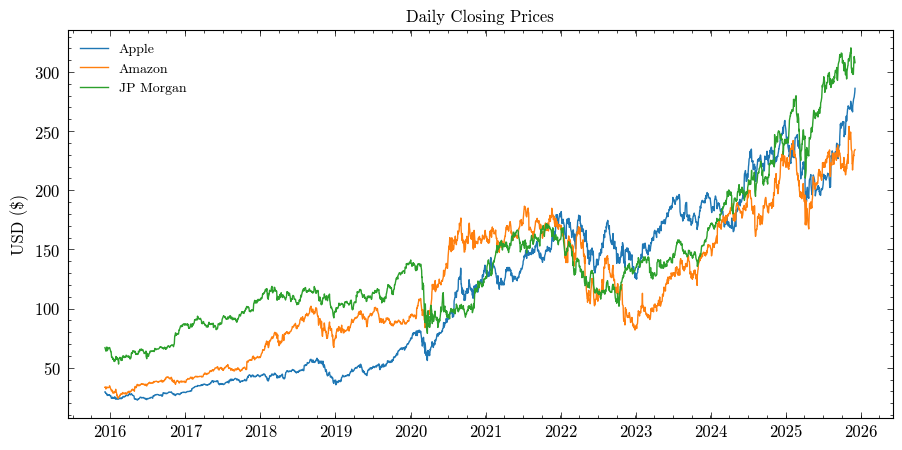

In [113]:
plt.figure(figsize=(10,5))
plt.title('Daily Closing Prices')
plt.plot(pivoted['date'], pivoted['AAPL'], label='Apple')
plt.plot(pivoted['date'], pivoted['AMZN'], label = 'Amazon')
plt.plot(pivoted['date'], pivoted['JPM'], label = 'JP Morgan')

plt.ylabel('USD ($)')
plt.legend()

plt.savefig(f'../Figures/Assignment09/daily.png', dpi = 300)
plt.show()

#### 1.2


summary statistics

In [116]:
daily

,date,Symbol,open,high,low,close,volume
2512,2015-12-07,AAPL,29.74,29.97,29.45,29.57,111557048.0
2513,2015-12-08,AAPL,29.36,29.65,29.22,29.56,115394960.0
2514,2015-12-09,AAPL,29.41,29.42,28.77,28.91,146376420.0
2515,2015-12-10,AAPL,29.01,29.24,28.88,29.04,99358104.0
2516,2015-12-11,AAPL,28.80,28.85,28.21,28.30,154481644.0
...,...,...,...,...,...,...,...
10647,2025-11-25,RKLB,42.03,42.81,40.38,42.60,7204127.0
10648,2025-11-26,RKLB,43.24,43.59,41.37,41.93,7895709.0
10649,2025-11-28,RKLB,42.51,42.70,41.80,42.14,3916342.0
10650,2025-12-01,RKLB,41.15,41.30,39.99,40.37,8581508.0


In [ ]:

daily['returns'] = daily.groupby('Symbol')['close'].transform(
    lambda x: x.pct_change()
)


In [122]:
summary = daily.groupby('Symbol')['returns'].agg(
    avg_log_return='mean',
    volatility='std',
    min_return='min',
    max_return='max',
    n_obs='count'
)

print(summary)

        avg_log_return  volatility  min_return  max_return  n_obs
Symbol                                                           
AAPL          0.001072    0.018351   -0.128652    0.153288   2511
AMZN          0.000990    0.020726   -0.140526    0.135326   2511
BE            0.002475    0.059107   -0.425000    0.591867   1849
JPM           0.000759    0.017413   -0.149649    0.180125   2511
PLTR          0.003204    0.044845   -0.213080    0.308014   1299
RKLB          0.002286    0.048157   -0.204167    0.373095   1265


### 1.3 

Trading logic